In [1]:
import pandas as pd
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
import numpy as np
from numpy import linalg as LA
from googletrans import Translator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
import random 
import igraph.test
from igraph import *
import csv
import numpy as np
import networkx as nx
import operator
import copy
from IPython.core.display import display, SVG
import math

In [2]:
#!pip install textblob
#!pip install googletrans
#!pip install vaderSentiment

In [3]:
data = pd.read_csv(r"./Dataset/#LawyersVsDelhiPolice_follower_followee_network.csv", encoding="utf-8")
data.tail()

,account_created_at,followerIDs,followers_count,friendIDs,friends_count,id,location,name,screen_name,user_id,verified
204,NaN,"1680535969, 865243790327545857, 11953297317276...",103,none,1034,205,NaN,Red hototo,redhototo7,1101514889158307841,False
205,NaN,"1106457638, 4617997158, 931892289378516992, 11...",421,none,249,206,NaN,Raj🇮🇳,rajs51,2377384326,False
206,NaN,"1107636733590626304, 921228135919579137",2,none,33,207,NaN,Gunjan Sinha,GunjanS51846484,1136675114039332864,False
207,NaN,"1167867240458391553, 23891573, 2587241916, 147...",447,none,334,208,Federated States of Micronesia,NoCallSigns,NoCallSigns,115637552,False
208,NaN,"1151501886261886978, 1189868482546077696, 1196...",6057,none,490,209,"Rajasthan, India",Gautam Tanwar,GautamTanwar_,815205990,False


In [4]:
tweet = pd.read_csv(r"./Dataset/#LawyersVsDelhiPolice_tweets.csv", encoding="utf-8")

In [5]:
tweet.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url
0,x287048581,x1191768222699159552,2019-11-05 17:24:20,ratheeshvij,"When a state govt has to be destabilised, @Ami...",Twitter Web App,144,NaN,NaN,NaN,...,23106,35057,2011-04-24 06:32:27,False,NaN,NaN,NaN,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1130424427...
1,x4547767873,x1191768215216484352,2019-11-05 17:24:19,skpaap,"""पूछने नहीं, बताने आया हूं - हम अभी mla की sho...",Twitter for Android,140,NaN,NaN,NaN,...,19983,30977,2015-12-13 14:03:28,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/45477678...,NaN,http://pbs.twimg.com/profile_images/1127241422...
2,x4547767873,x1191767926304456705,2019-11-05 17:23:10,skpaap,Finally Faddu baba knocking the doors of RSS (...,Twitter for Android,140,NaN,NaN,NaN,...,19983,30977,2015-12-13 14:03:28,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/45477678...,NaN,http://pbs.twimg.com/profile_images/1127241422...
3,x900314384290922496,x1191768215174541313,2019-11-05 17:24:19,co7s0Kgfc1QyPXd,"10 घंटे बाद खत्म हुआ पुलिसवालों का धरना, मांगी...",Twitter for Android,119,NaN,NaN,NaN,...,17010,68940,2017-08-23 11:10:51,False,https://t.co/TPgN5k78tm,https://youtu.be/MLTpgwzYDGU,NaN,https://pbs.twimg.com/profile_banners/90031438...,NaN,http://pbs.twimg.com/profile_images/1104719150...
4,x2867849762,x1191768205871550464,2019-11-05 17:24:16,ravisinghh1787,So much unrest was brewing in the force and in...,Twitter for Android,125,NaN,NaN,NaN,...,1701,374,2014-10-20 18:02:40,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/28678497...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7659238081...


### Note:
- To improve the data 29 Users were added Using developer access
- And Their sentiment was analysed using their previous tweets on this topic if available.
- Hindi tweets were translated using google translate api.
- Sentiment analysis using VADER in python.


In [6]:
#!pip install emoji

We used emoji package to separate the text from emojis.

In [7]:
import emoji
import string


def extract_emojis(str):
    return ''.join(c for c in str if c not in emoji.UNICODE_EMOJI)

To get all the unique Id's

In [8]:
stat = tweet["user_id"]
req = stat.apply(lambda x: x[1:] ).unique()

### Using Google Translate API 

There are many tweets written in hindi and other languages.So in the next code block we preprocessed the text and used Google translator API to translate all the tweets to english.

In [9]:
tweet.sort_values(by=['user_id', 'created_at'])
txt_mat=dict()
for j in req:
    txt_mat[j]=[]
translate_urls = ["translate.google.com", "translate.google.co.kr",
                      "translate.google.at", "translate.google.de",
                      "translate.google.ru", "translate.google.ch",
                      "translate.google.fr", "translate.google.es"]
translator = Translator(service_urls=translate_urls)
for index,i in tweet.iterrows():
    
    txt_mat[i["user_id"][1:]].append(translator.translate(extract_emojis(i['text'].translate(str.maketrans('', '', string.punctuation))),dest='en').text)


In [10]:
text=[]
for j in req:
    text.append(txt_mat[j][0])
len(text)

180

### Sample text translation:

In [11]:
tweet['text'][1]

'"पूछने नहीं, बताने आया हूं - हम अभी mla की shopping में busy हैं"\n#WhereIsAmitShah \n#LawyersVsPolice #DelhiPolice #LawyersVsDelhiPolice #DelhiPoliceVsLawyers #MaharashtraAssemblyPolls #ShivSenaVsBJP https://t.co/JLg7LdS0Ns'

In [12]:
translator.translate(extract_emojis(tweet['text'][1].translate(str.maketrans('', '', string.punctuation))),dest='en').text

'I come to tell you not to ask we are now busy in shopping of mla\nWhereIsAmitShah\nLawyersVsPolice DelhiPolice LawyersVsDelhiPolice DelhiPoliceVsLawyers MaharashtraAssemblyPolls ShivSenaVsBJP httpstcoJLg7LdS0Ns'

In [13]:
tweet["retweet_user_id"]=tweet["retweet_user_id"].fillna('')

In [14]:
obj = list(data['user_id'].values)
twid = []
for i in tweet['user_id'].values:
    twid.append(i[1:])

In [15]:
for i in range(0,len(obj)):
    obj[i]=str(obj[i])

In [16]:
edge_list = []
vertices_list=[]
for i in data["user_id"]:
    for j in str(data.loc[data.user_id == i]["followerIDs"].values[0]).split(', '):
        if j in obj:
            t=(j,i)
            edge_list.append(t)
    vertices_list.append(i)

## Trust matrix:
The following code snippet will take edge as input and returns Trust matrix.Each element in the matrix is the normalized sum of  number of times the ith user retweeted the jth user (where i represents row and j represents column). 


In [17]:
def get_weight_mat(edge_list):
    p=dict()
    i=0
    mat=[[0 for i in range(data["user_id"].size)] for j in range(data["user_id"].size)]
    for j in obj:
        p[j]=i
        i+=1
    
    for index,i in tweet.iterrows():
        if i["retweet_user_id"][1:] in obj: 
            mat[p[i["user_id"][1:]]][p[i["retweet_user_id"][1:]]]+=5
            t=(p[i["user_id"][1:]],p[i["retweet_user_id"][1:]])
            
                            
    for i in range(data["user_id"].size):
        s=0
        for j in range(data["user_id"].size):
            s+=mat[i][j]
        if(s!=0):
            for j in range(data["user_id"].size):
                mat[i][j]/=s
            
    return mat

In [18]:
adj_mat=get_weight_mat(edge_list)

## Sentiment Analysis:

We used VADER(Valence Aware Dictionary and Sentiment Reasoner) Sentiment Analyzer to extract sentiment scores from the text.Based on these scores we categorized the tweets into positive,negative and neutral tweets.


In [19]:
def clean_tweet(tweet): 
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 

def sentiment_scores(sentence): 
  
    sid_obj = SentimentIntensityAnalyzer() 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    return sentiment_dict['compound'] 


## Trust matrix:
The following code snippet will take edge as input and returns Trust matrix.Each element in the matrix is the normalized sum of  number of times the ith user retweeted the jth user (where i represents row and j represents column). 

In [20]:
def deGroot(A, s, tMax,c_eps):
    N=len(obj)
    At = []
    z = s
    zPrev = z
    NORM_TYPE = np.inf;
    opinions = np.zeros((N,tMax+1))
    for i in range(N):
        opinions[i][0] = z[i]
        
    for t  in range(tMax):
        z = np.matmul(A,zPrev)
        zPrev = z
        for i in range(N):
            opinions[i][t+1] = z[i]
        
        opinionDiff = [opinions[i][t]-opinions[i][t+1] for i in range(N)]
        
        if (LA.norm(opinionDiff, NORM_TYPE) < c_eps):
            print('Reached equilibrium after ' +str(t)+ ' rounds.')
            break
   
    
    return opinions


Varialble s is used to store the initial beliefs of the users

In [21]:
s=[]
for i in range(len(req)):
    s.append(sentiment_scores(text[i]))
for i in range(len(req),len(obj)):
    s.append(1)


In [22]:
text_final=[]
for j in req:
    text_final.append(txt_mat[j][len(txt_mat[j])-1])
len(text_final)

180

Varialble sf is used to store the final beliefs of the users

In [23]:
sf=[]
for i in range(len(req)):
    sf.append(sentiment_scores(text_final[i]))
for i in range(len(req),len(obj)):
    sf.append(s[i])

In [24]:
Gm = igraph.Graph.TupleList(edge_list, directed = True)
out = plot(Gm)
out.save('Outputs/Original_Law.png')

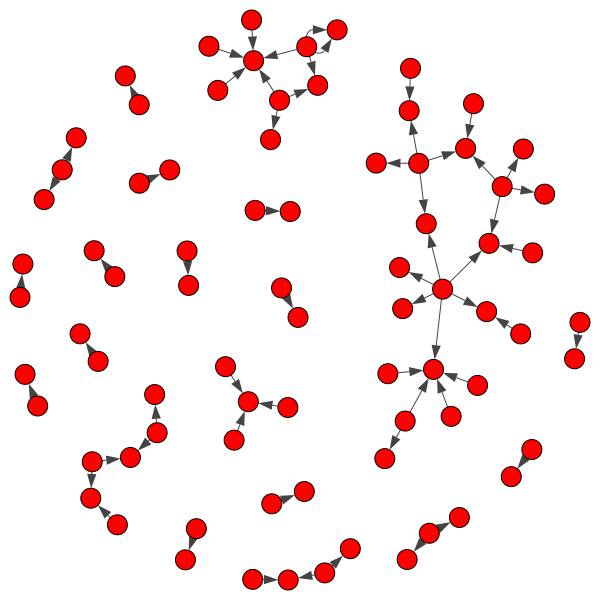

In [25]:
out

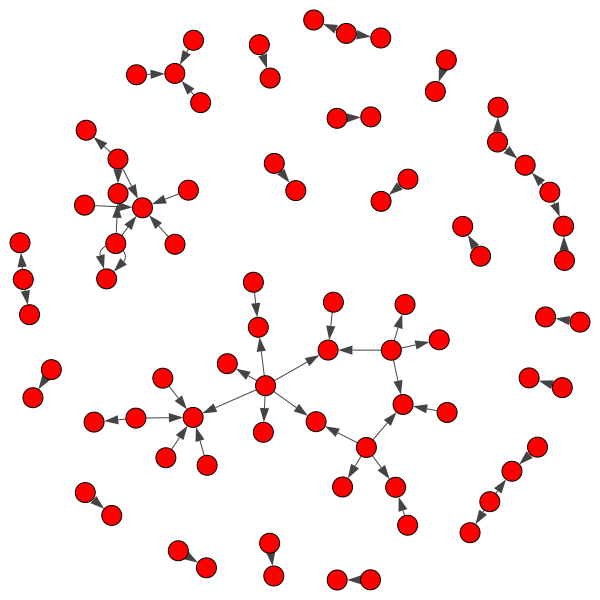

In [26]:
o=deGroot(adj_mat,s,10,0.0001)

Reached equilibrium after 2 rounds.


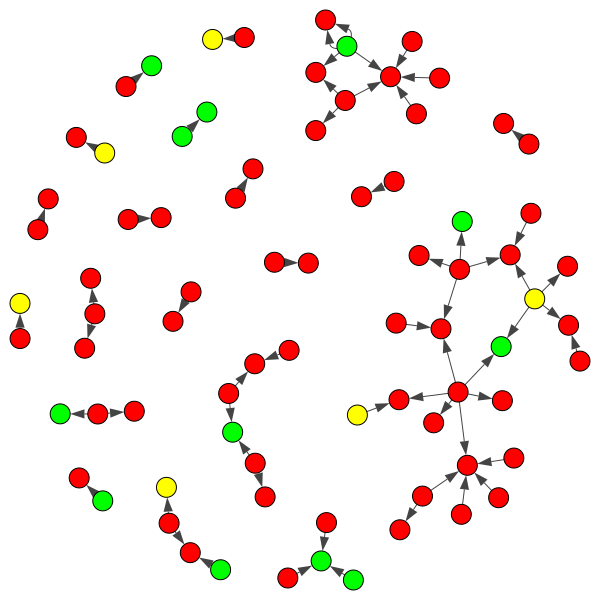

In [27]:
n=0
p=0
z=0
col = []
for i in range(0,180):
    if o[i][0]<=0 :
        col.append('red')
        n+=1
    elif o[i][0]>=0.5:
        col.append('green')
        p+=1
    elif o[i][0]>0 and s[i]<0.5:
        col.append('yellow')
        z+=1
Gm.vs['color'] = col
out = plot(Gm)
out.save('Outputs/1Degroot_Law.png')
out

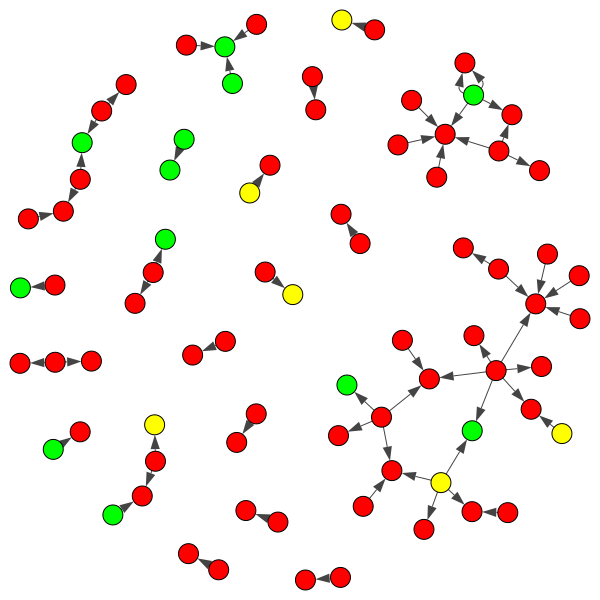

In [28]:
t=[n,p,z]
t

[125, 30, 25]

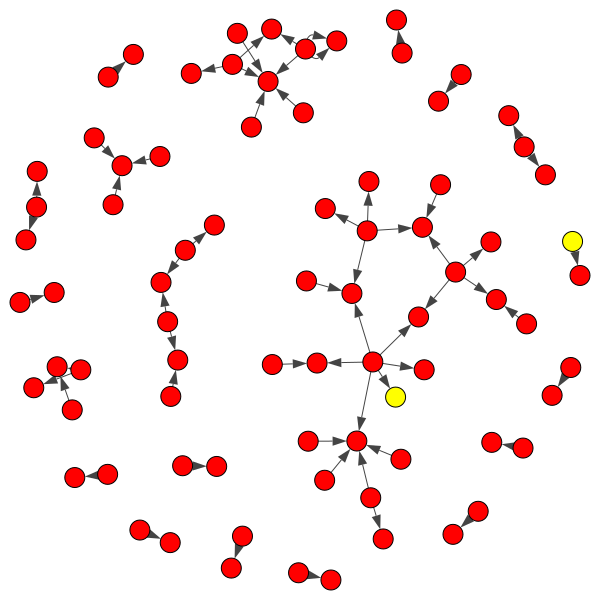

In [29]:
n=0
p=0
z=0
col = []
for i in range(0,180):
    if o[i][1]<=0 :
        col.append('red')
        n+=1
    elif o[i][1]>=0.5:
        col.append('green')
        p+=1
    elif o[i][1]>0 and s[i]<0.5:
        col.append('yellow')
        z+=1
Gm.vs['color'] = col
out = plot(Gm)
out.save('Outputs/2Degroot_Law.png')
out

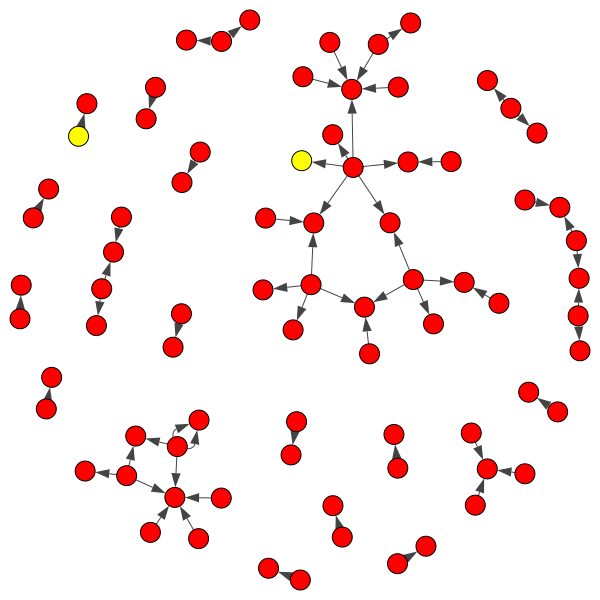

In [30]:
t=[n,p,z]
t

[175, 0, 5]

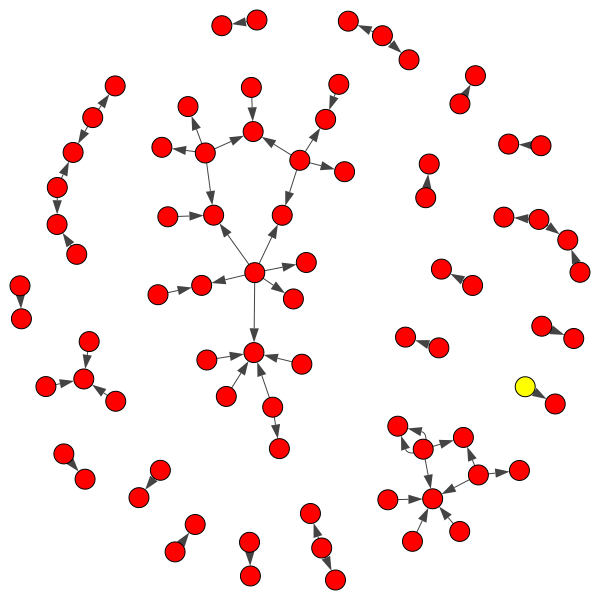

In [31]:
n=0
p=0
z=0
col = []
for i in range(0,180):
    if o[i][2]<=0 :
        col.append('red')
        n+=1
    elif o[i][2]>=0.5:
        col.append('green')
        p+=1
    elif o[i][2]>0 and s[i]<0.5:
        col.append('yellow')
        z+=1
Gm.vs['color'] = col
out = plot(Gm)
out.save('Outputs/3Degroot_Law.png')
out

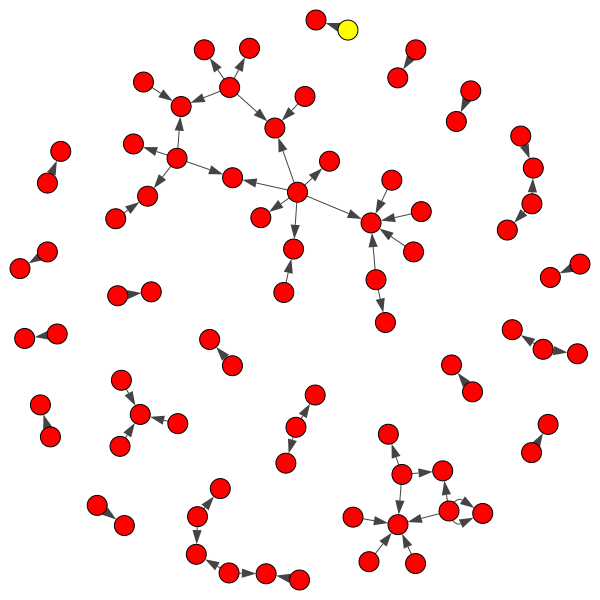

In [32]:
t=[n,p,z]
t

[176, 0, 4]

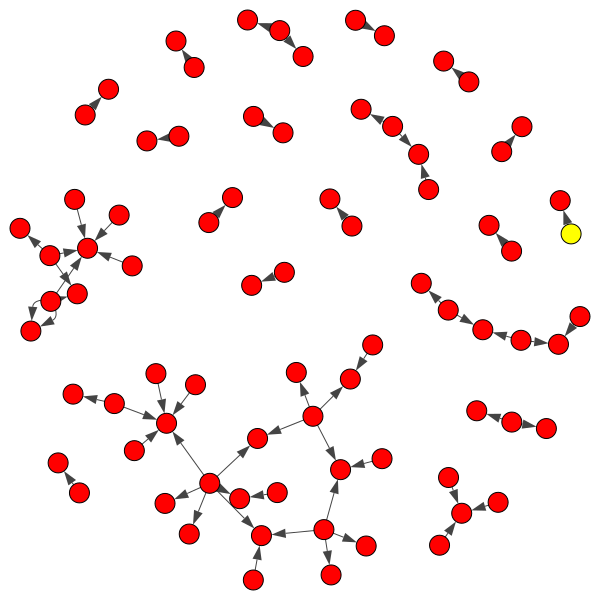

In [33]:
n=0
p=0
z=0
col = []
for i in range(0,180):
    if o[i][3]<=0 :
        col.append('red')
        n+=1
    elif o[i][3]>=0.5:
        col.append('green')
        p+=1
    elif o[i][3]>0 and s[i]<0.5:
        col.append('yellow')
        z+=1
Gm.vs['color'] = col
out = plot(Gm)
out.save('Outputs/4Degroot_Law.png')
out

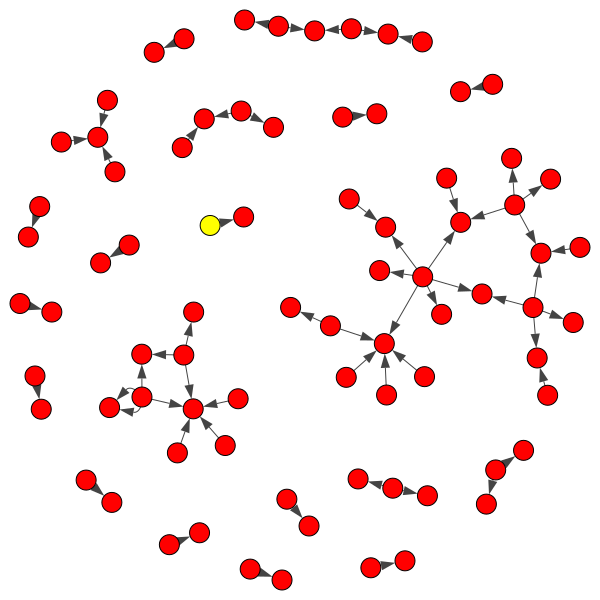

In [34]:
t=[n,p,z]
t

[176, 0, 4]

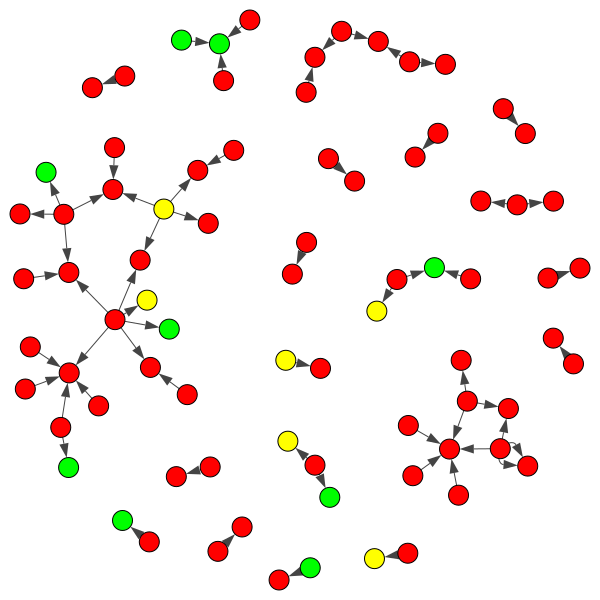

In [35]:
n=0
p=0
z=0
col = []
for i in range(0,180):
    if sf[i]<=0 :
        col.append('red')
        n+=1
    elif sf[i]>=0.5:
        col.append('green')
        p+=1
    elif sf[i]>0 and s[i]<0.5:
        col.append('yellow')
        z+=1
Gm.vs['color'] = col
out = plot(Gm)
out.save('Outputs/5_LawFinal.png')
out

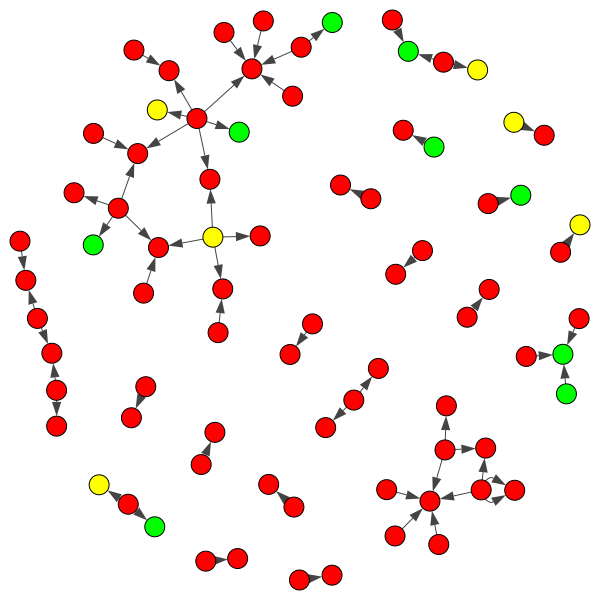

In [36]:
t=[n,p,z]
t

[128, 25, 25]

### Plots given below shows how the predictions are getting converged
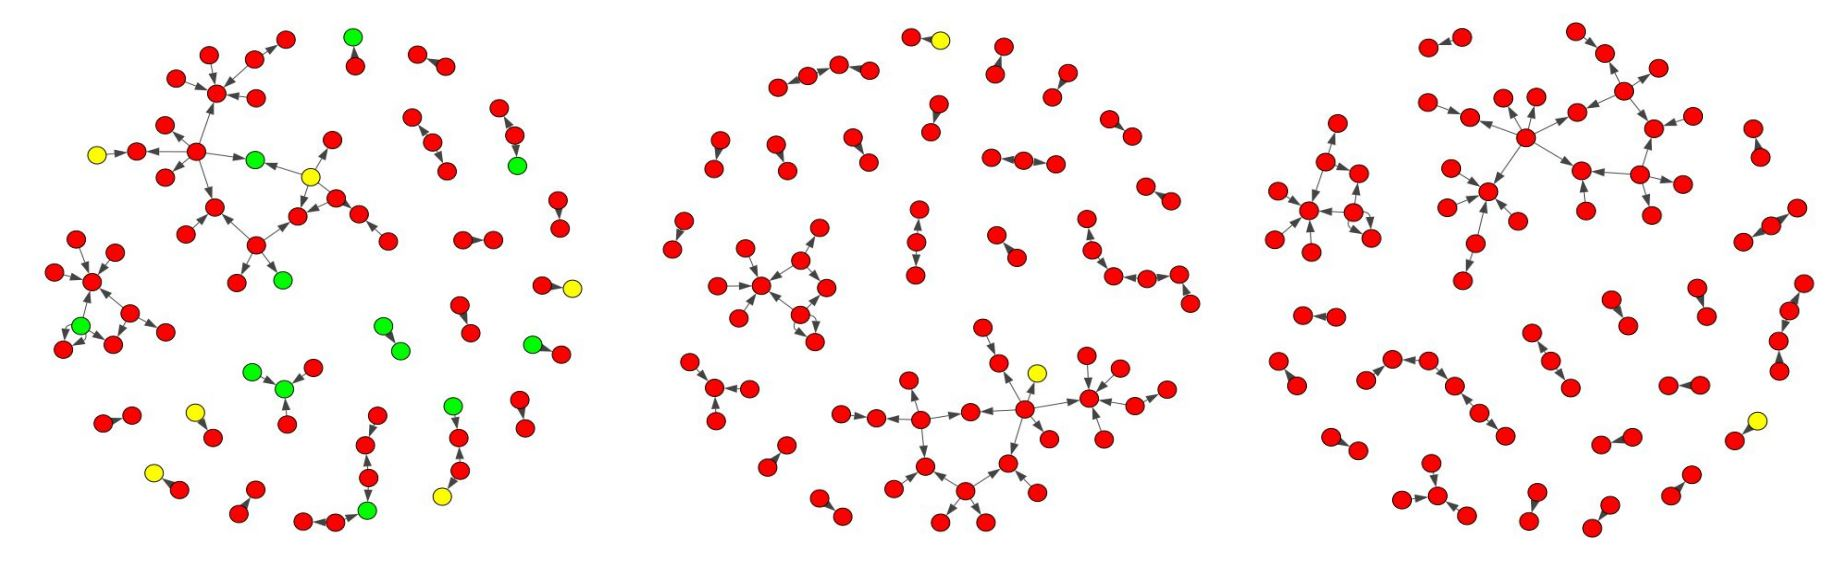

the predictions got converged just in one iteration and we could see that there is no learning happening here,the reason could be that the number of retweets is almost equal to number of users and very few users retweeted more than once.

In [37]:
for i in range(len(o)):
    if o[i][0]<=0 :
        print("negative")
    elif o[i][0]>=0.5:
        print("positive")
    elif o[i][0]>0 and s[i]<0.5:
        print("neutral")
    
    print (text[i])

negative
When a state govt has to be destabilised AmitShah is on the spot

When MLAs amp MPs are to be bought using black money Amit Shah is there

But when law amp order has collapsed  in Delhi the Home Minister is nowhere to be found

WhereIsAmitShah LawyersVsDelhiPolice
negative
I come to tell you not to ask we are now busy in shopping of mla
WhereIsAmitShah
LawyersVsPolice DelhiPolice LawyersVsDelhiPolice DelhiPoliceVsLawyers MaharashtraAssemblyPolls ShivSenaVsBJP httpstcoJLg7LdS0Ns
negative
10 hours later went sought encompass ended policemen all demands LawyersVsDelhiPolice
Httpstchokiplarbtbpdo
neutral
So much unrest was brewing in the force and intelligence had no inputs about it Strange  LawyersVsDelhiPolice
negative
Lawyers are new breed of sharks new breed of mafia dons dragging the cases endlessly to fill their own pockets They along with the doctors politicians and bureaucrats have joined the hated most list
LawyersVsDelhiPolice
LawyersVsPolice
negative
LawyersVsDelhiPolic

IndexError: list index out of range

### Sentiment analysis using VADER in python.
#### Samples
#### Negative:

- “Amit shah sitting at home and reading
  comment under trend
  #WhereIsAmitShah “ 
- “Police and lawyers fighting this script
  Akshay Kumar confused Roudi Rathod
  2 Bnau or Jolly LLB 3
  LawyersVsDelhiPolice” 
  
#### Positive:
- “If you were given a choice to support one side
  in LawyersVsDelhiPolice issue which fruit
  would you like to eat in winters”
- “Now what police is asking for protection and
  lawyers for justice Time change very fast We
  believe in lawyers but their behaviour is
  snatching our faith in judiciary and the dead
  word Justice”